In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [2]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 26.14 MiB/s, done.
Updating files: 100% (12939/12939), done.


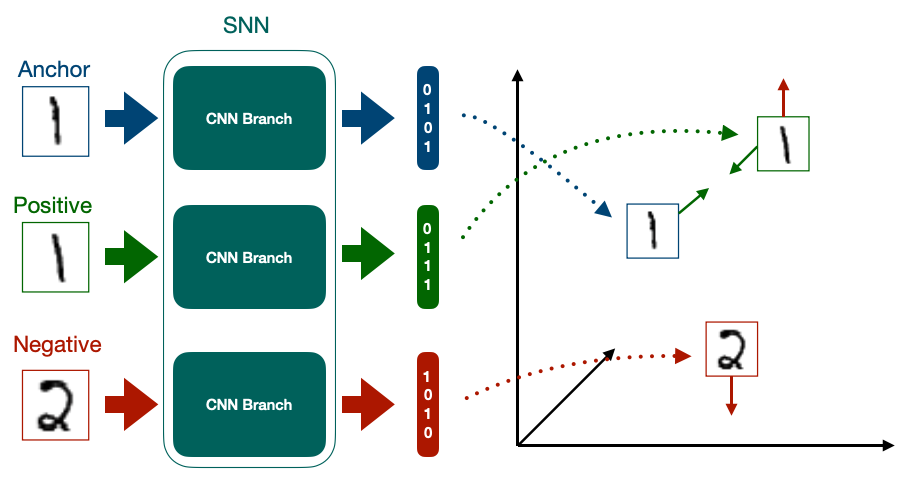

# Imports

In [3]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [5]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 1e-3
EPOCHS = 15

DEVICE = 'cuda'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [7]:
# try an example to illustrate the selection of Anchor, Positive and Negative
# Image
row = df.iloc[14]

A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)


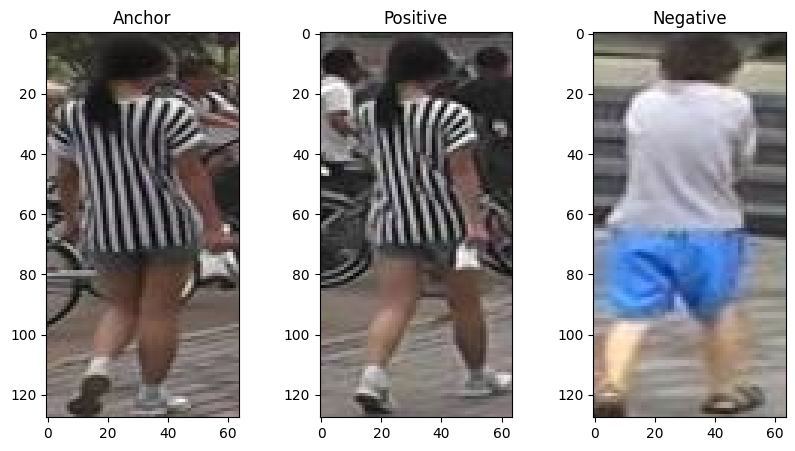

In [8]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 5))

ax1.set_title('Anchor')
ax1.imshow(A_img)

ax2.set_title('Positive')
ax2.imshow(P_img)

ax3.set_title('Negative')
ax3.imshow(N_img)

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Create APN Dataset

In [10]:
class APN_Dataset(Dataset):
  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)

    A_img = torch.from_numpy(A_img).permute(2,0,1) / 255.0
    P_img = torch.from_numpy(P_img).permute(2,0,1) /255.0
    N_img = torch.from_numpy(N_img).permute(2,0,1) /255.0

    return A_img, P_img, N_img

In [11]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f'Size of trainset : {len(trainset)}')
print(f'Size of validset : {len(validset)}')



Size of trainset : 3200
Size of validset : 800


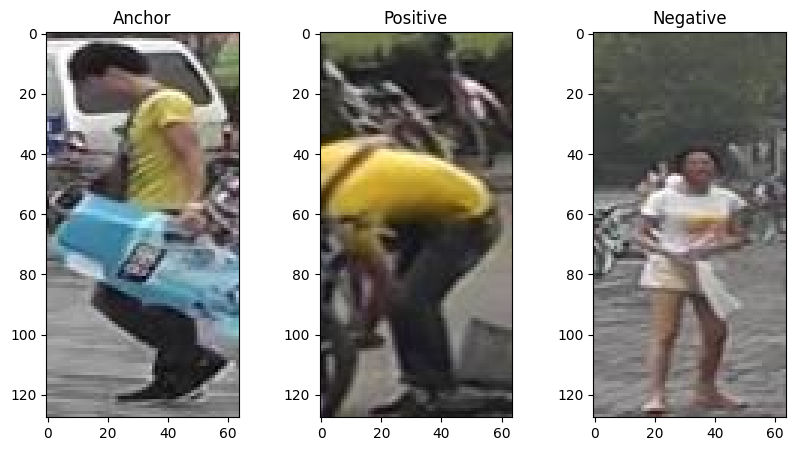

In [12]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [13]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [14]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [15]:
for A,P,N in trainloader:
  break;

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [25]:
class APN_Model(nn.Module):

  def __init__(self, emb_size =512):
    super(APN_Model, self).__init__()

    self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features= emb_size)

  def forward(self, images):
    return self.efficientnet(images)

In [29]:
model = APN_Model()
model.to(DEVICE)

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size

# Create Train and Eval function

In [22]:
def train_fn(model, dataloader, optimizer, criterion):
  model.train() # ON Dropout
  total_loss = 0
  for A, P, N in tqdm(dataloader):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)
    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss / len(dataloader)

In [23]:
def valid_fn(model, dataloader, criterion):
  model.eval() # OFF Dropout
  total_loss = 0
  with torch.no_grad():
    for A, P, N in tqdm(dataloader):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)
      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()
    return total_loss / len(dataloader)

In [30]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [31]:
best_valid_loss = np.inf
# use loss function for each epoch
for epoch in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = valid_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss

  print(f"Epoch : {epoch+1} | Train Loss : {train_loss} | Valid Loss : {valid_loss}")

100%|██████████| 25/25 [00:03<00:00,  6.28it/s]


Epoch : 1 | Train Loss : 0.6161212205886841 | Valid Loss : 0.5893015360832214


100%|██████████| 25/25 [00:03<00:00,  7.55it/s]


Epoch : 2 | Train Loss : 0.2857771344482899 | Valid Loss : 0.38294232308864595


100%|██████████| 25/25 [00:03<00:00,  7.49it/s]


Epoch : 3 | Train Loss : 0.24659306555986404 | Valid Loss : 0.3163251054286957


100%|██████████| 25/25 [00:03<00:00,  7.53it/s]


Epoch : 4 | Train Loss : 0.09930825881659984 | Valid Loss : 0.2218793201446533


100%|██████████| 25/25 [00:03<00:00,  7.48it/s]


Epoch : 5 | Train Loss : 0.06163869127631187 | Valid Loss : 0.22588982105255126


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Epoch : 6 | Train Loss : 0.06482325047254563 | Valid Loss : 0.30861458778381345


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Epoch : 7 | Train Loss : 0.06950372397899628 | Valid Loss : 0.19158801078796386


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Epoch : 8 | Train Loss : 0.053037711679935456 | Valid Loss : 0.21955843925476073


100%|██████████| 25/25 [00:03<00:00,  7.46it/s]


Epoch : 9 | Train Loss : 0.04533975139260292 | Valid Loss : 0.18421698838472367


100%|██████████| 25/25 [00:03<00:00,  6.81it/s]


Epoch : 10 | Train Loss : 0.030114790201187135 | Valid Loss : 0.15714408457279205


100%|██████████| 25/25 [00:04<00:00,  5.85it/s]


Epoch : 11 | Train Loss : 0.04085548788309097 | Valid Loss : 0.16052748769521713


100%|██████████| 25/25 [00:04<00:00,  6.02it/s]


Epoch : 12 | Train Loss : 0.04215971127152443 | Valid Loss : 0.1583471891283989


100%|██████████| 25/25 [00:03<00:00,  7.12it/s]


Epoch : 13 | Train Loss : 0.04685260385274887 | Valid Loss : 0.228326213657856


100%|██████████| 25/25 [00:03<00:00,  7.49it/s]


Epoch : 14 | Train Loss : 0.04620595484972 | Valid Loss : 0.16470919251441957


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]

Epoch : 15 | Train Loss : 0.060635257437825205 | Valid Loss : 0.17915311574935913


# Get Anchor Embeddings

In [35]:
def get_encoding_csv(anc_img_model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2,0,1)/255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0)) #(c,h,w) -> (bs, c,h,w)
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

  encodings = np.array(encodings)
  encodings = pd.DataFrame(encodings)
  df_enc = pd.concat([anc_img_names, encodings], axis = 1)
  return df_enc

In [36]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [01:02<00:00, 63.84it/s]


In [37]:
df_enc.to_csv('encoding.csv', index = False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,0.195268,-0.269881,-0.440354,0.296604,0.204072,-0.137006,-0.283174,1.166008,-0.539318,...,0.555700,-0.333043,-0.099504,0.098732,-0.370207,-0.533493,0.641242,-0.451767,-0.763180,-0.705945
1,1420_c3s3_061978_03.jpg,-0.259236,0.003265,-0.461710,0.275950,0.505406,-0.168162,-0.458386,0.793457,-0.083405,...,0.446868,-0.263978,-0.052261,0.585502,-0.217250,-0.681186,0.496915,-0.646277,-0.764393,-0.752263
2,1420_c5s3_062565_05.jpg,-0.317782,-0.251883,-0.878632,0.282871,0.644383,-0.445356,-0.403715,0.848739,-0.423800,...,0.487359,-0.131426,-0.043810,0.370412,-0.287781,-0.920400,0.417368,-0.564366,-0.823392,-0.536308
3,1420_c6s3_085592_04.jpg,0.417336,-0.376239,-0.548955,0.092320,0.172783,-0.009707,-0.105723,0.814241,-0.428348,...,0.108888,-0.258466,0.087433,0.028370,-0.195667,-0.594545,0.311892,-0.334133,-0.603622,-0.757808
4,0663_c5s3_085987_03.jpg,0.449271,0.338490,0.178325,-0.013402,-0.628832,0.055411,-0.258489,0.196256,0.009727,...,0.467270,-0.134704,0.159336,-0.549943,-0.573757,0.020133,0.223721,0.380695,0.170142,-0.541603


# Inference

In [38]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc - anc_enc_arr).T))
  return dist

In [55]:
idx = 43
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2,0,1) / 255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [56]:
anc_enc_arr = df_enc.iloc[:,1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [57]:
distance = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i:i+1,:])
  distance = np.append(distance, dist)

In [58]:
closest_idx = np.argsort(distance)

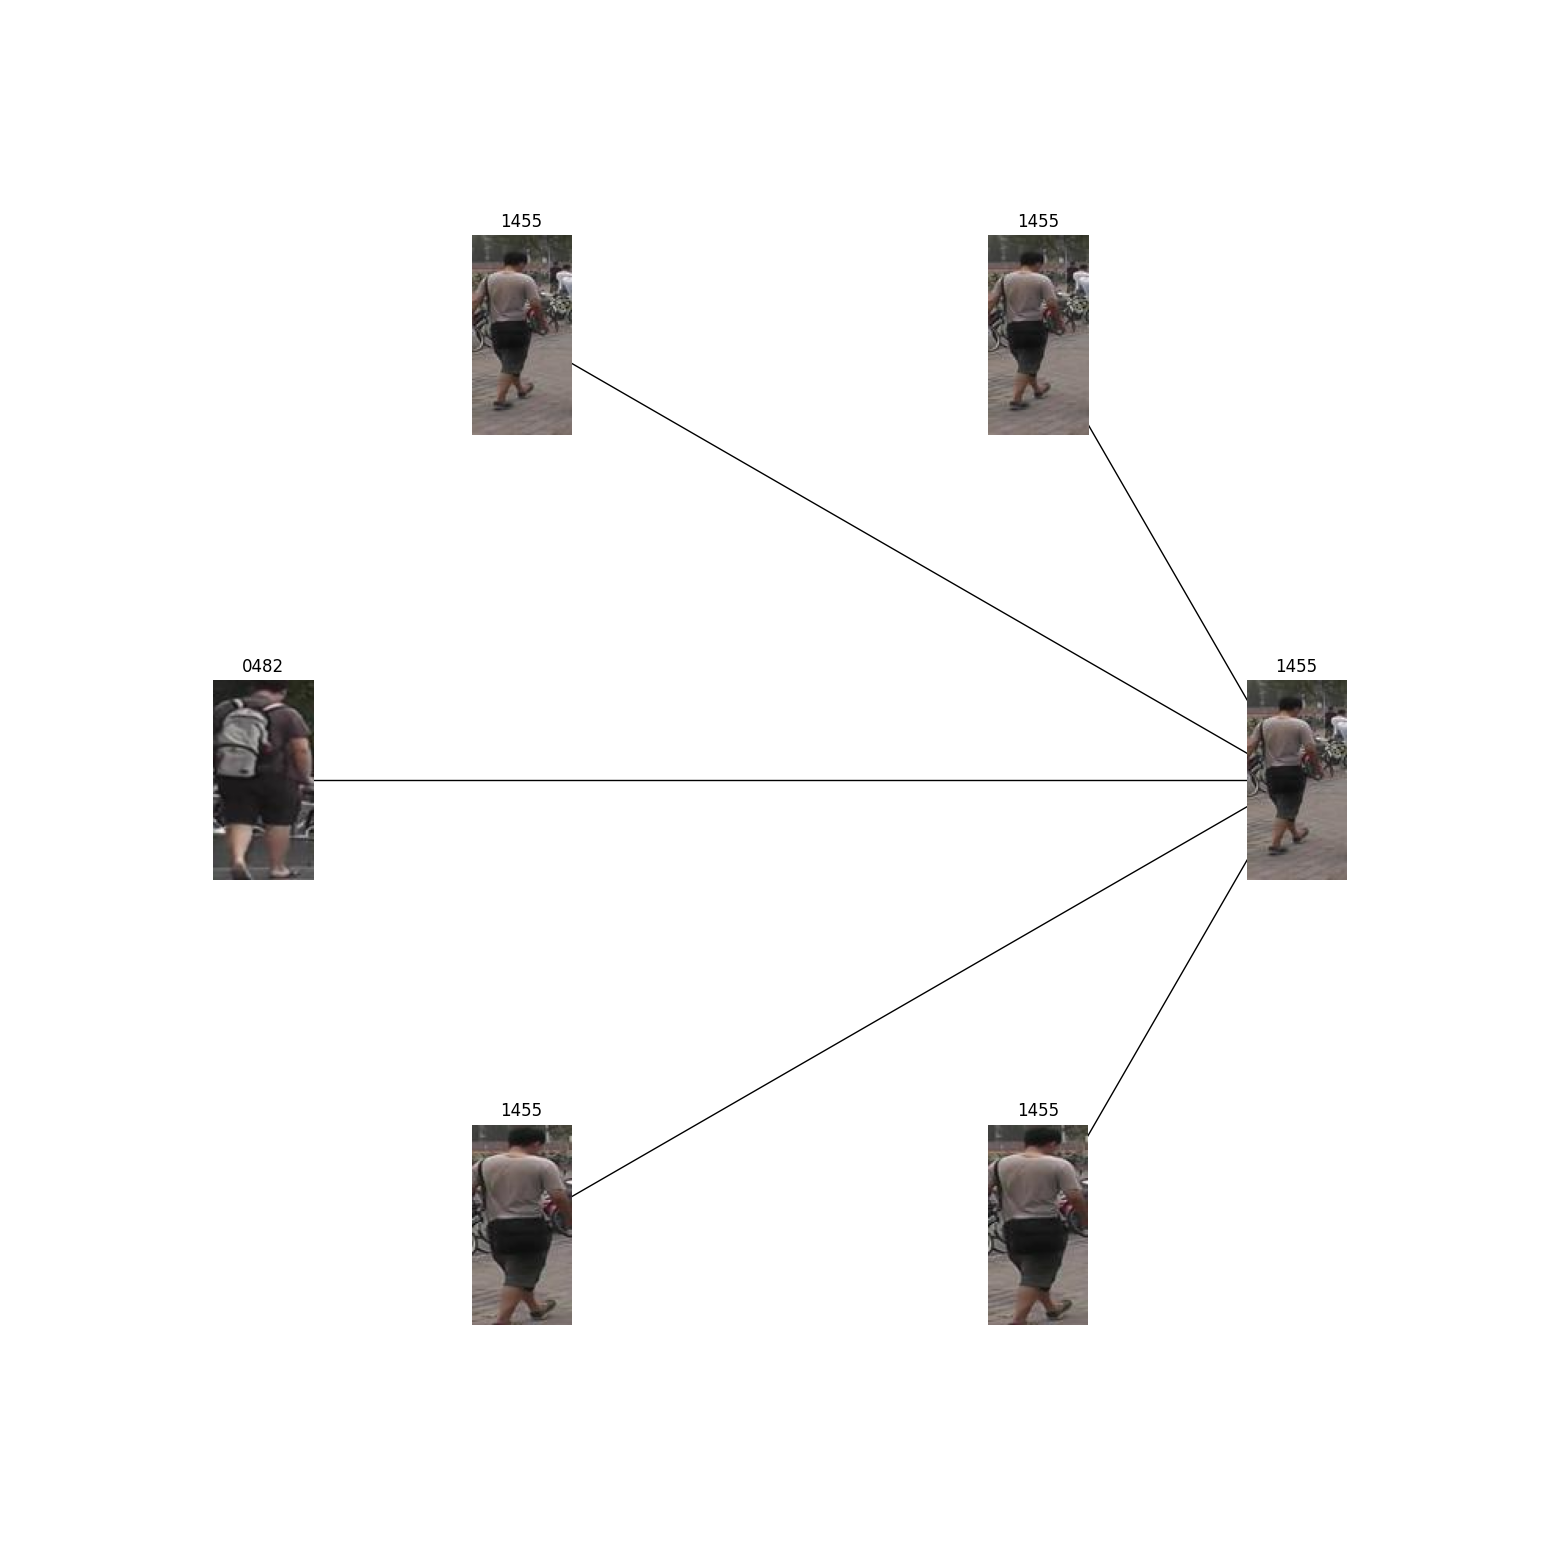

In [61]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);